In [ ]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression


## Yêu cầu bào toán
- Sử dụng python và opencv
- Tạo ảnh trắng size 400*200
- vẽ hình vuông size 20*20 ở chính giữa
- Chứng minh bản thân đúng

### 1.Khởi tạo tham số

In [ ]:
# Khoi tao shape cua image va rec (bang dictionary)
'''
    Arguments:
        width: chieu rong cua anh (pixels)
        height: chieu cao cua anh (pixels)
        channels: so kenh mau cua anh (1 kenh cho anh xam, 3 kenh cho anh mau RGB)
        color: mau nen cua anh (RGB)
'''

image_attributes = {
                'width': 200,
                'height': 400,
                'channels': 3,
                'color': [255, 255, 255]
               } # white color in BGR

rec_attributes = {
                    'width': 20,
                    'height': 20,
                    'channels': 3,
                    'color': [0, 255, 0] # green theo yeu cau cua bai toan
                 }

### 2. Xây dựng Module tạo ảnh

In [ ]:
class Image_Render:
    def __init__(self, image_attribute: dict) :
        self.width = image_attribute['width']
        self.height = image_attribute['height']
        self.channels = image_attribute['channels']
        self.color = image_attribute['color']

    def image_render_by_loop(self):
        # Khởi tạo mảng numpy
        image = np.zeros((self.height, self.width, self.channels), dtype=np.uint8)
        for i in range(self.height):
            for j in range(self.width):
                image[i, j] = self.color
        return image

    def image_render_by_numpy(self):
        return np.full((self.height, self.width, self.channels), self.color, dtype=np.uint8)



In [ ]:
image = Image_Render(image_attributes).image_render_by_numpy()
rec = Image_Render(rec_attributes).image_render_by_numpy()

In [ ]:
image.shape, rec.shape

((400, 200, 3), (20, 20, 3))

### 3. Xác định tâm của ảnh

##### 3.1 Giao của 2 đường chéo

***Phương pháp đại số***

Tính chất của hình chữ nhật: giao điểm của 2 đường chéo trong hình chữ nhật là tâm của hình chữ nhật đó.


**Phương trình tổng quát**

Cho 2 điểm $$A(x_1, y_1) \&  B(x_2, y_2)$$.

Vector chỉ phuơng u :$$ \vec{u} = (x_2 - x_1, y_1 - y_2)  $$
Vector pháp tuyến n thỏa mãn :
$$ \vec{n} * \vec{u} = 0
\begin{cases}
\vec{n} = (-y_u, x_u) \\
\vec{n} = (y_u, -x_u) \\
\end{cases}
$$

Phương trình đường thẳng đi qua A có dạng: $$ x_n * (x - x_1) + y_n * (y - y_1) = 0 \\ x_n * x + y_n * y - (x_n * x_1 + y_n * y_1) = 0$$

Sau khi tính đường thẳng đi qua 2 điểm, Giải hệ phương trình

***Tính***

In [ ]:


def bresenham_line(A: tuple, B: tuple):
    """
    Vẽ một đường thẳng từ (x1, y1) đến (x2, y2)
    sử dụng thuật toán Bresenham.
    Trả về một danh sách các tọa độ điểm ảnh.
    """
    x1, y1 = A
    x2, y2 = B
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    # points = []
    input = []
    output = []
    x, y = x1, y1

    while True:
        input.append(x)
        output.append(y)

        if x == x2 and y == y2:
            break

        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x += sx
        if e2 < dx:
            err += dx
            y += sy

    return np.array(input), np.array(output)


In [ ]:
X, y = bresenham_line((0, 0), (image_attributes['width']-1, image_attributes['height']-1))

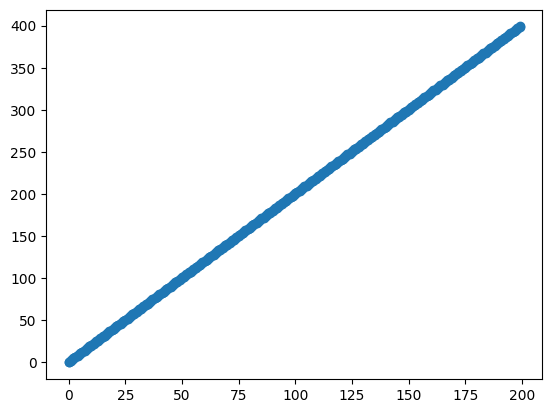

In [ ]:
plt.scatter(X, y)
plt.show()

##### Linear Regression
Phương trình đường chéo có dạng
$$ \alpha * X + \beta = y
\begin{cases}
\alpha: \text{hệ số chặn} \\
\beta: \text{hệ số góc} \\
X: \text{đầu vào} \\
y: \text{đầu ra}
\end{cases}
$$

Hồi quy (Regression)



In [ ]:
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)
model = LinearRegression().fit(X, y)
a1, b1 = model.coef_, model.intercept_  # coef_ = [[2.]], intercept_ = [-0.]
a1, b1

(array([[2.]]), array([0.5]))

In [ ]:
# 2. Định nghĩa hàm log-likelihood
def log_likelihood(params, X, y):
    """
    Hàm log-likelihood cho mô hình hồi quy tuyến tính.
    params[0] là beta_0 (hệ số chặn)
    params[1] là beta_1 (hệ số góc)
    params[2] là sigma (độ lệch chuẩn của sai số)
    """
    beta_0, beta_1, sigma = params

    # Tính giá trị dự đoán từ mô hình
    y_pred = beta_0 + beta_1 * X # flatten() để chuyển X từ (n, 1) sang (n,)
    # Tính phần còn lại (sai số)
    residuals = y - y_pred

    # Tính log-likelihood
    # Hàm PDF của phân phối chuẩn: L(theta) = tích của PDF(yi | xi, theta)
    # Log-likelihood: LL(theta) = tổng của ln(PDF(yi | xi, theta))
    # ln(PDF) = -0.5 * ln(2*pi) - ln(sigma) - 0.5 * ((y - y_pred) / sigma)^2
    n = len(y)
    log_L = -n/2 * np.log(2 * np.pi) - n * np.log(sigma) - (1/(2 * sigma**2)) * np.sum(residuals**2)

    # SciPy's `minimize` tìm cực tiểu, nên ta phải tối thiểu hóa log-likelihood âm
    return -log_L

# 3. Ước lượng các tham số bằng cách tối thiểu hóa hàm log-likelihood âm
# Đặt giá trị khởi tạo cho các tham số (thường là một phỏng đoán hợp lý)
initial_params = [0, 0, 1]

# Sử dụng minimize của SciPy để tìm cực tiểu của hàm log-likelihood âm
# Tham số bounds được sử dụng để đảm bảo sigma luôn dương
bounds = [(None, None), (None, None), (0.01, None)]
result = minimize(log_likelihood, initial_params, args=(X, y), bounds=bounds)

# 4. Hiển thị kết quả ước lượng
estimated_beta_0, estimated_beta_1, estimated_sigma = result.x

print(f"Tham số ước lượng: beta_0 = {estimated_beta_0:.4f}")
print(f"Tham số ước lượng: beta_1 = {estimated_beta_1:.4f}")

Tham số ước lượng: beta_0 = 0.5000
Tham số ước lượng: beta_1 = 2.0000


In [ ]:
y_reverse = np.flip(y)

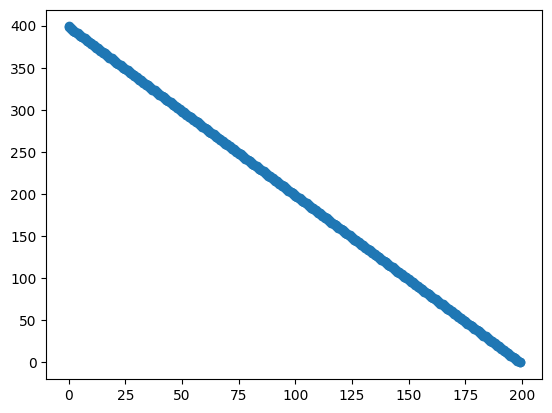

In [ ]:
plt.scatter(X, y_reverse)
plt.show()

In [ ]:
model = LinearRegression().fit(X, y_reverse)
a2, b2 = model.coef_, model.intercept_
a2, b2

(array([[-2.]]), array([398.5]))

In [ ]:
result = minimize(log_likelihood, initial_params, args=(X, y_reverse), bounds=bounds)

# 4. Hiển thị kết quả ước lượng
estimated_beta_0, estimated_beta_1, estimated_sigma = result.x

print(f"Tham số ước lượng: beta_0 = {estimated_beta_0:.4f}")
print(f"Tham số ước lượng: beta_1 = {estimated_beta_1:.4f}")

Tham số ước lượng: beta_0 = 398.5000
Tham số ước lượng: beta_1 = -2.0000


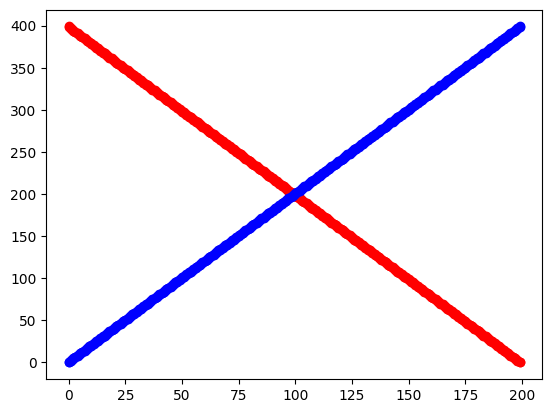

In [ ]:
plt.scatter(X, y_reverse, color='red')
plt.scatter(X, y, color='blue')
plt.show()

In [ ]:
a = abs(a1 - a2)
b = abs(b1 - b2)
x_center = b/a
y_center = a1 * x_center + b1
print(f"Tọa độ trung tâm : x = {x_center}, y = {y_center}")

Tọa độ trung tâm : x = [[99.5]], y = [[199.5]]


In [ ]:
x_center = image_attributes/2

***Tọa độ trung tâm***

Phương trình giao của 2 đoạn thẳng trong không gian Oxy
$$2 * x + 0.5 = -2 * x + 398.5$$
$$x = 99.5, y = 199.5$$

Ảnh là một biểu diễn của ma trận pixel có dạng **m*n**

Vị trí của 1 pixel có dạng
$$A[i, j]
\begin{cases}
i, & \{ i \in \mathbb{N} |  i: 0  \rightarrow n \} \\
j, & \{ i \in \mathbb{N} |  j: 0  \rightarrow m \}
\end{cases}
$$

Giả sử
$$ x \in [99, 100] \&y \in [199, 200]
\begin{cases}
x = 99, y= 199 \\
x = 100, y= 199 \\
x = 99, y= 200 \\
x = 100, y= 200 \\
\end{cases}
$$


In [ ]:
def center_ratio (a1, b1, a2, b2):
  a = abs(a1 - a2)
  b = abs(b1 - b2)
  x = b/a
  y = a1 * x + b1
  return x_center, y_center


In [ ]:
x_center, y_center = center_ratio(a1, b1, a2, b2)
print(f"Tọa độ trung tâm : x = {x_center}, y = {y_center}")

Tọa độ trung tâm : x = [[99.5]], y = [[199.5]]


/tmp/ipython-input-3094120094.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.rectangle(test_image, (math.floor(x_center), math.floor(y_center)), (math.ceil(x_center), math.ceil(y_center)), (0, 255, 0), -1)


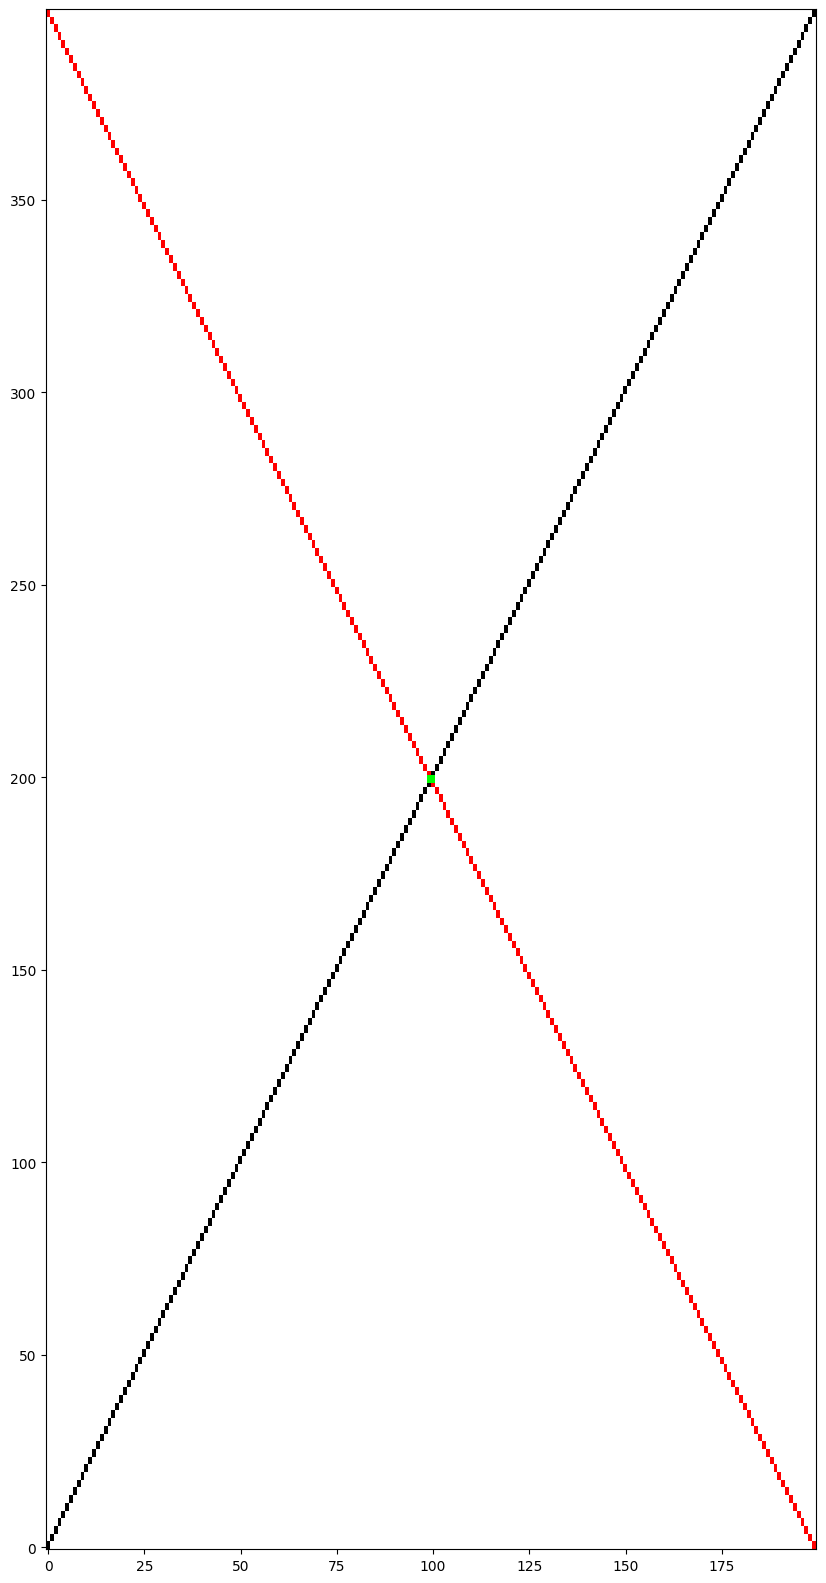

In [ ]:
cv2.line(image, (0, 0), (image_attributes['width']-1, image_attributes['height']-1), (0, 0, 0), 1)
cv2.line(image, (0, image_attributes['height']-1), (image_attributes['width']-1, 0), (255, 0, 0), 1)
test_image = image
cv2.rectangle(test_image, (math.floor(x_center), math.floor(y_center)), (math.ceil(x_center), math.ceil(y_center)), (0, 255, 0), -1)
plt.figure(figsize=(10, 20))
plt.imshow(test_image, origin='lower')
plt.show()

In [ ]:
def rec_bounding(x_center, y_center, rec_attributes):
  if rec_attributes['width'] % 2 == 1:
    rec_bounding_horizontal = [math.floor(x_center - rec_attributes['width']//2), math.ceil(x_center + rec_attributes['width']//2 + 1)]

  if rec_attributes['height'] % 2 == 1:
    rec_bounding_vertical = [math.floor(y_center - rec_attributes['height']//2), math.ceil(y_center + rec_attributes['height']//2 + 1)]

  if rec_attributes['width'] % 2 == 0:
    rec_bounding_horizontal = [math.floor(x_center - rec_attributes['width']//2), math.ceil(x_center + rec_attributes['width']//2)]

  if rec_attributes['height'] % 2 == 0:
    rec_bounding_vertical = [math.floor(y_center - rec_attributes['height']//2), math.ceil(y_center + rec_attributes['height']//2)]

  return rec_bounding_horizontal, rec_bounding_vertical

In [ ]:
rec_bounding_horizontal, rec_bounding_vertical = rec_bounding(x_center, y_center, rec_attributes)
rec_bounding_horizontal, rec_bounding_vertical

/tmp/ipython-input-549162352.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rec_bounding_horizontal = [math.floor(x_center - rec_attributes['width']//2), math.ceil(x_center + rec_attributes['width']//2)]
/tmp/ipython-input-549162352.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rec_bounding_vertical = [math.floor(y_center - rec_attributes['height']//2), math.ceil(y_center + rec_attributes['height']//2)]


([89, 110], [189, 210])

/tmp/ipython-input-2541075768.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (math.floor(x_center) - i, math.floor(y_center) - i),
/tmp/ipython-input-2541075768.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (math.ceil(x_center) + i, math.ceil(y_center) + i ),


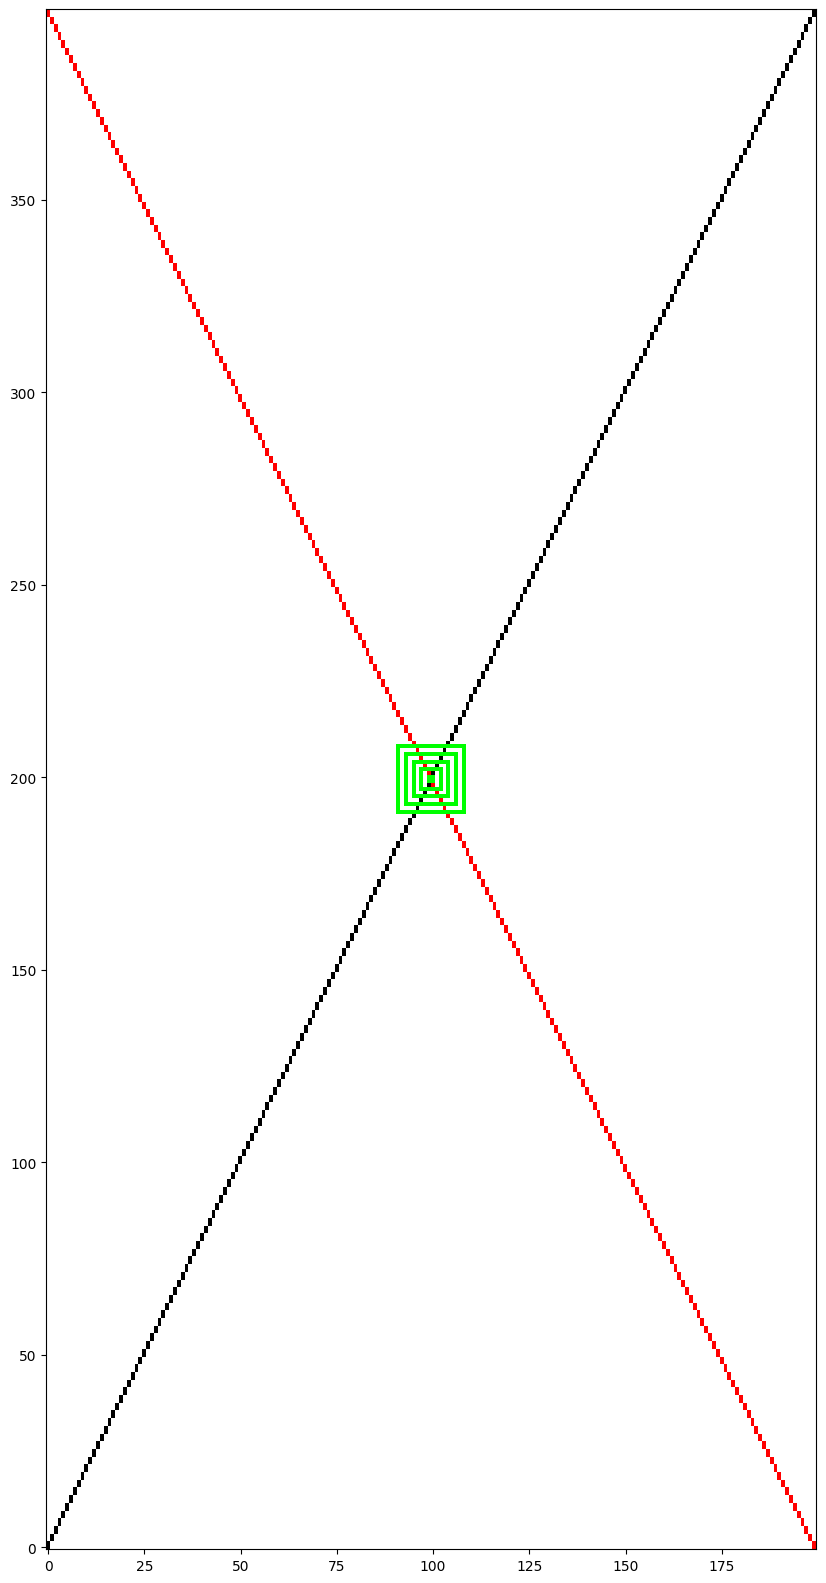

In [ ]:
cv2.line(image, (0, 0), (image_attributes['width']-1, image_attributes['height']-1), (0, 0, 0), 1)
cv2.line(image, (0, image_attributes['height']-1), (image_attributes['width']-1, 0), (255, 0, 0), 1)
test_image = image
for i in range (0, 10, 2):
    cv2.rectangle(test_image,
                (math.floor(x_center) - i, math.floor(y_center) - i),
                (math.ceil(x_center) + i, math.ceil(y_center) + i ),
                (0, 255, 0), 1)

plt.figure(figsize=(10, 20))
plt.imshow(test_image, origin='lower')
plt.show()